# Data Collection

## Objectives

1. Fetch data from kaggle.
2. Prepare data for model training.

## Inputs

1. Authentication Kaggle JSON file

## Outputs

1. Image only datasets

## Comments

Kaggle dataset is already divided in train, validate and test folder. It is important to calculate ratios and redistribute if needed.

---

## Import packages

In [23]:
import numpy
import os

## Set working directory

In [24]:
print(os.getcwd())

/workspace/OCTreader


In [25]:
os.chdir('/workspace/OCTreader')
print(f'New working directory: {os.getcwd()}')

New working directory: /workspace/OCTreader


## Installing Kaggle

In [26]:
# install kaggle==1.5.12 package
%pip install kaggle==1.5.12

You should consider upgrading via the '/home/gitpod/.pyenv/versions/3.8.12/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Configuring working directory and authentication for Kaggle

In [27]:
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()
! chmod 600 kaggle.json

## Fetch data from Kaggle

In [28]:
# Variables containing kaggle data path and local directory to host input data
data_path = 'paultimothymooney/kermany2018/data'
destination_folder = 'inputs/OCTdata'
! kaggle datasets download -d {data_path} -p {destination_folder}

100%|█████████████████████████████████████▉| 10.8G/10.8G [05:19<00:00, 42.0MB/s]
100%|██████████████████████████████████████| 10.8G/10.8G [05:19<00:00, 36.5MB/s]


In [29]:
import zipfile

# Find the zip file with kaggle data
zip_kaggle_dataset = os.listdir(destination_folder)

with zipfile.ZipFile(destination_folder + '/' + zip_kaggle_dataset[0], 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

os.remove(destination_folder + '/' + zip_kaggle_dataset[0])

## Remove redundant data

There are two folders with the same data, we will eliminate one.

In [30]:
# Listing existing folders
data_folders = os.listdir(destination_folder)
data_folders

['OCT2017 ', 'oct2017']

In [31]:
import shutil

# We will keep this folder
keeping_dir = 'OCT2017 '

for current_dir in os.listdir('inputs/OCTdata'):
    if current_dir != keeping_dir:
        shutil.rmtree('inputs/OCTdata/' + current_dir)


There is a trailing space in the data folder that is best to remove.

In [32]:
data_folders = os.listdir(destination_folder)

# Removing trainling space if found in folder's name
if  data_folders[0][-1] == ' ':
    os.rename(destination_folder + '/' + data_folders[0],
              destination_folder + '/' + data_folders[0][0: -1])

We check if the trailing space has been removed

In [33]:
data_folders = os.listdir(destination_folder)
data_folders[0]

'OCT2017'

# Data Cleaning and Split

Data is now divided in three folders: train, val and test. Each of these folders contains four folders for the different labels. In this step non-images files are removed and ratios of train, val and test are calculated.

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def remove_non_images(data_dir):
    '''
    The function checks data_dir and removes
    any files without image extension
    and counts image files in folder
    '''
    image_extensions = ['jpeg', 'png', 'gif']
    image_count = 0
    for image_file in os.listdir(data_dir):
        if image_file.split('.')[1] in image_extensions:
            image_count += 1
        else:
            os.remove(data_dir + image_file)

    return image_count


def explore_directories(root_dir):
    '''
    Sweeps all directories calling the non_image removing function
    counts the total of images per folder and makes a summary on df    
    '''
    # empty dataframe
    df = pd.DataFrame(columns=['purpose', 'label', 'count'])
    labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    split_dirs = ['train', 'val', 'test']
    for split_dir in split_dirs:
        for label in labels:
            data_dir = root_dir + split_dir + '/' + label
            # count per label
            count = remove_non_images(data_dir)
            # add record of count per directory
            df = df.append({'purpose': split_dir, 'label': label, 'count': count}, ignore_index = True)

    # create a log plot to observe distribution of images
    sns.barplot(data=df, x='label', y='count', hue='purpose')
    plt.yscale('log')
    plt.show()
    print('Viasualisation of images distribution across folders')
    df_summary = (df.groupby(by=['purpose',]).sum().drop('label', axis=1))
    print('Summary of images distribution across folders')
    df_summary['ratios'] = df_summary['count']/df_summary['count'].sum()
    print(df_summary)
    return df_summary.drop('count', axis=1)



Expected ratios are train = 0.7, val = 0.1 and test = 0.2. If this condition is not met, the files need to be redistributed.

/tmp/ipykernel_14806/2175611446.py:42: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


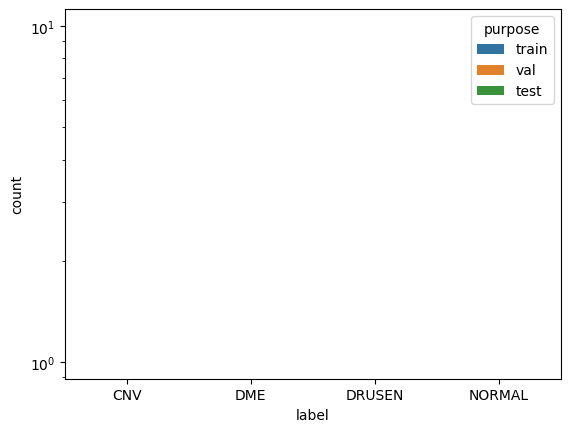

Viasualisation of images distribution across folders
Summary of images distribution across folders
         count  ratios
purpose               
test         0     NaN
train        0     NaN
val          0     NaN
['CNV', 'DME', 'DRUSEN', 'NORMAL']


FileExistsError: [Errno 17] File exists: 'inputs/OCTdata/OCT2017/temp/CNV'

In [22]:
import shutil
import random


def check_split_ratios(df, train_ratio, val_ratio, test_ratio):
    '''
    Function checks if ratios in data satisfy the requirements
    and returns a boolean
    '''

    # defining split tolerance
    tolerance = 0.02
    
    train_true = df.loc['train', 'ratios']
    val_true = df.loc['val', 'ratios']

    train_accept = (train_true < train_ratio + tolerance) and (train_true > train_ratio - tolerance)
    val_accept = (val_true < val_ratio + tolerance) and (val_true > val_ratio - tolerance)

    return train_accept and val_accept


def temporary_data_relocation(data_dir):
    '''
    Copies images from train, val and test folders to a new folder,
    reshuffles images and finally carries a split with the right ratios
    '''
    labels = os.listdir(data_dir + 'test')
    print(labels)
    split_dirs = ['train', 'val', 'test']
    # Create temporary folders to host images
    os.makedirs(data_dir + 'temp')
    for label in labels:
        destination_dir = data_dir + 'temp/' + label
        os.makedirs(destination_dir)   
    # move images to temporary location folders
    for split_dir in split_dirs:
        for label in labels:
            origin_dir = data_dir + split_dir + '/' + label
            destination_dir = data_dir + 'temp/' + label
            list_images = os.listdir(origin_dir)
            for image in list_images:
                shutil.move(origin_dir +'/' + image,
                            destination_dir + '/' + image)


def image_final_move(right_split, data_dir, t_ratio, v_ratio, labels):
    '''
    Move images either from temporary location
    or original folders to new location
    '''
    root_dir = 'inputs/OCTdata/'
    split_dirs = ['train', 'val', 'test']
    # if the original split on folders is correct folders are just relocated
    if right_split:
        for split_dir in split_dirs:
            shutil.move(data_dir + split_dir,
                        root_dir + split_dir)
    # otherwise files from temporary folder must be split in to different split_dirs
    else:
        for split_dir in split_dirs:
            os.makedirs(root_dir + split_dir)
 
        for label in labels:
            origin_dir = root_dir + 'temp/' + label
            for split_dir in split_dirs:
                os.makedirs(root_dir + split_dir + '/' + label)
            images = os.listdir(origin_dir)
            random.shuffle(images)
            n_image = 0
            for image in images:
                if n_image < len(images) * t_ratio:
                    shutil.move()
                elif:
                
                else:




def split_data(train_ratio, val_ratio, test_ratio):
    '''
    The function creates verifies data is correctly split into train, test and val
    folders, if they are not, it reorganinses in the correct split
    '''
    data_dir = 'inputs/OCTdata/OCT2017/'
    labels = os.listdir(data_dir + 'test')
    df = explore_directories(data_dir)
    ratios_sum = train_ratio + val_ratio + test_ratio
    if ratios_sum == 1.0:
        right_split = check_split_ratios(df, train_ratio, val_ratio, test_ratio)
        if right_split:
            image_final_move(right_split, data_dir, train_ratio, val_ratio, labels)
        else:
            temporary_data_relocation(data_dir)
    else:
        print('====================================')
        print('====================================')
        print('The sum of ratios must be equal to 1')
        print('please recall the function with the right ratios')

split_data(train_ratio=0.7, val_ratio=0.1, test_ratio=0.2)

